In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# corchete signado
def csign(x, alpha):
    return np.sign(x) * np.abs(x)**alpha

In [3]:
# Generador de referencia con derivadas
def ref_signal(w, y0, Ts):
    t = 0
    while True:
        ref = y0 * np.sin(w*t)
        ref_dot = y0 * w * np.cos(w*t)
        ref_ddot = -y0 * w**2 * np.sin(w*t)
        yield ref, ref_dot, ref_ddot
        t += Ts

In [4]:
def controller_observer(Ts, e1_hat0=0, e2_hat0=0, sigma0=0, 
                       k1=23.4, k2=31.6, k3=20, l1=2, l2=1.1, lam=20, aN=1):
    e1_hat = e1_hat0
    e2_hat = e2_hat0
    sigma = sigma0
    
    while True:
        e1 = yield u if 'u' in locals() else 0
        
        # Error del observador
        e1_err = e1_hat - e1
        
        # Señal de control auxiliar (común para observador y controlador)
        u_aux = e1 + k2*csign(e2_hat, 3/2)
        
        # Control final (ecuación 12)
        u = -k1*csign(u_aux, 1/3) - k3*sigma
        
        # Observador (ecuación 13)
        e1_hat_dot = -lam*l1*csign(e1_err, 2/3) + e2_hat
        e2_hat_dot = -lam**2*l2*csign(e1_err, 1/3) - k1*aN*csign(u_aux, 1/3)
        
        # Integral discontinua (ecuación 8)
        sigma_dot = np.sign(e1)
        
        # Integración
        e1_hat += Ts * e1_hat_dot
        e2_hat += Ts * e2_hat_dot
        sigma += Ts * sigma_dot

In [5]:
# Dinamica en coordenadas de error extendido (ecuación 9)
def plant_dynamics(Ts, w, th1=3, th2=1, e1_0=0, e2_0=0):
    e1, e2 = e1_0, e2_0
    while True:
        u, ref, ref_dot, ref_ddot = yield (e1, e2)
        
        # Sistema en coordenadas de error (ecuación 9)
        # e1 = y - yR, e2 = y_dot - yR_dot
        e1_dot = e2
        e2_dot = -th1*np.sin(e1 + ref) + (w^2)*ref + th2*u
        
         # sistema en Bes00
#         # m_q = 1+(np.cos(x1)**2)
#         # c_q = -0.5*np.sin(2*x1)
#         # g_q = 9.81*np.sin(x1)
        
#         # x1_dot = x2
#         # x2_dot = (1/m_q)*(u - g_q - c_q*(x2**2))
        
        # Integración (Euler)
        e1 += Ts * e1_dot
        e2 += Ts * e2_dot

In [6]:
# ------------------- Inicialización del Experimento -------------------

# Parámetros del experimento
Ts = 3e-5
tfinal = 30.0
steps = int(tfinal / Ts)
w = 1
y0 = 1
x1_0 = 0.5
x2_0 = 0.5
e1_0 = x1_0
e2_0 = x2_0 - w*y0

# Inicializar generadores
ref_gen = ref_signal(w=w, y0=y0, Ts=Ts)
ctrl_obs = controller_observer(Ts)
plant = plant_dynamics(Ts, w, e1_0=e1_0, e2_0=e2_0)

# Inicializar
ref, ref_dot, ref_ddot = next(ref_gen)
u = next(ctrl_obs)
e1, e2 = next(plant)

# Arrays para guardar datos
t_data = []
e1_data = []
u_data = []

In [7]:
# -------------- Loop principal -----------------

for i in tqdm(range(steps)):
    ref, ref_dot, ref_ddot = next(ref_gen)
    e1, e2 = plant.send((u, ref, ref_dot, ref_ddot))
    u = ctrl_obs.send(e1)
    
    # Guardar datos
    t_data.append(i * Ts)
    e1_data.append(e1)
    u_data.append(u)

# Convertir listas a arrays de numpy
t_data = np.array(t_data)
e1_data = np.array(e1_data)
u_data = np.array(u_data)

100%|████████████████████████████████████████| 1000000/1000000 [00:09<00:00, 104179.35it/s]


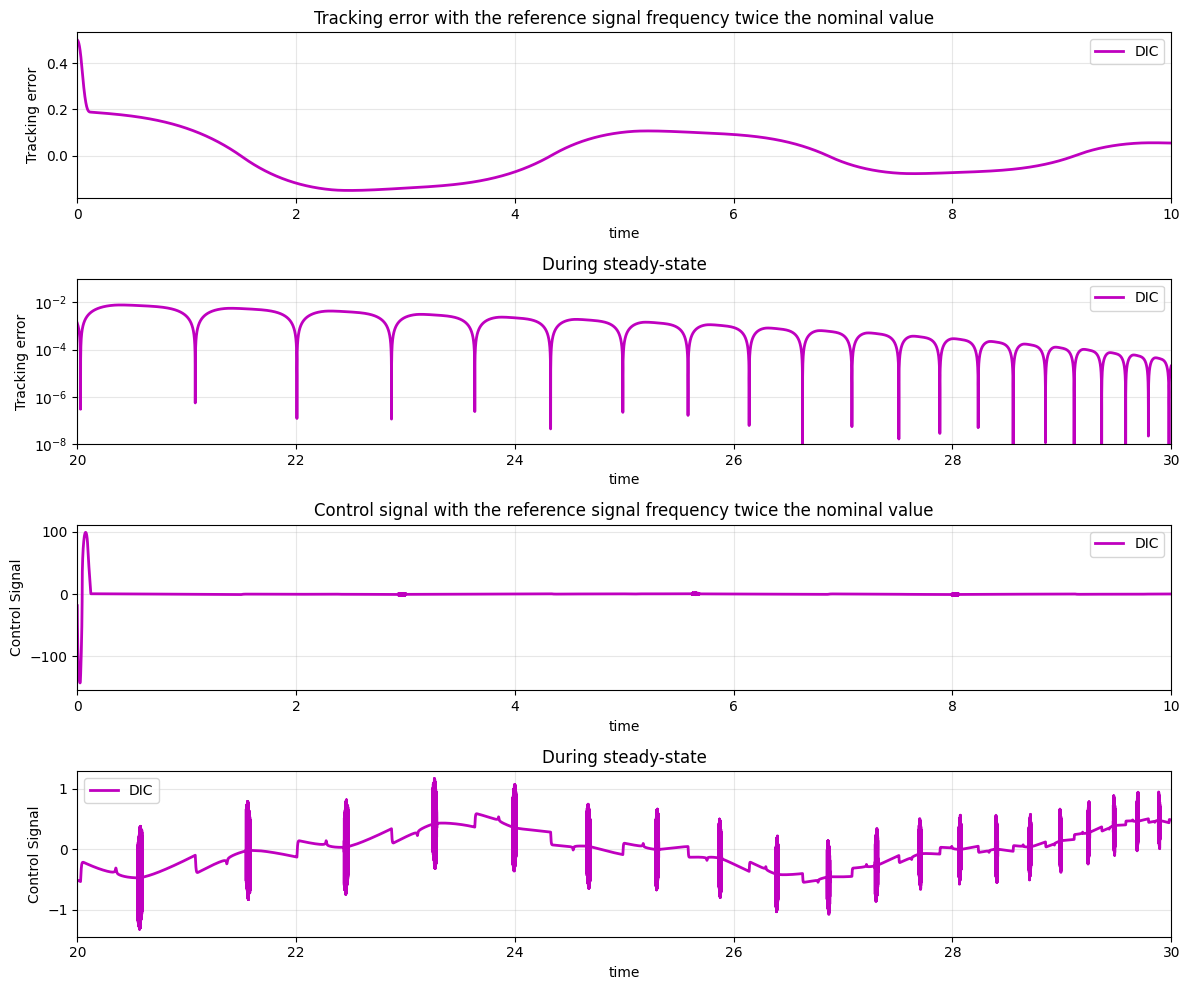

In [8]:
# Graficar resultados
plt.figure(figsize=(12, 10))

# Error durante período transitorio (primeros 10 segundos)
plt.subplot(4, 1, 1)
mask_transient = t_data <= 10.0
plt.plot(t_data[mask_transient], e1_data[mask_transient], 'm-', linewidth=2, label='DIC')
plt.ylabel('Tracking error')
plt.title('Tracking error with the reference signal frequency twice the nominal value')
plt.xlabel('time')
plt.xlim(0, 10)
plt.grid(True, alpha=0.3)
plt.legend()

# Error en estado estable (ESCALA LOGARÍTMICA, de 20 a 30 segundos)
plt.subplot(4, 1, 2)
mask_steady = (t_data >= 20.0) & (t_data <= 30.0)
plt.semilogy(t_data[mask_steady], np.abs(e1_data[mask_steady]) + 1e-10, 'm-', linewidth=2, label='DIC')
plt.ylabel('Tracking error')
plt.title('During steady-state')
plt.xlabel('time')
plt.xlim(20, 30)
plt.ylim(1e-8, 1e-1)  # Rango típico en escala log
plt.grid(True, alpha=0.3)
plt.legend()

# Control signal - período transitorio (primeros 10 segundos)
plt.subplot(4, 1, 3)
plt.plot(t_data[mask_transient], u_data[mask_transient], 'm-', linewidth=2, label='DIC')
plt.ylabel('Control Signal')
plt.title('Control signal with the reference signal frequency twice the nominal value')
plt.xlabel('time')
plt.xlim(0, 10)
plt.grid(True, alpha=0.3)
plt.legend()

# Control signal - estado estable (de 20 a 30 segundos)
plt.subplot(4, 1, 4)
plt.plot(t_data[mask_steady], u_data[mask_steady], 'm-', linewidth=2, label='DIC')
plt.ylabel('Control Signal')
plt.xlabel('time')
plt.title('During steady-state')
plt.xlim(20, 30)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

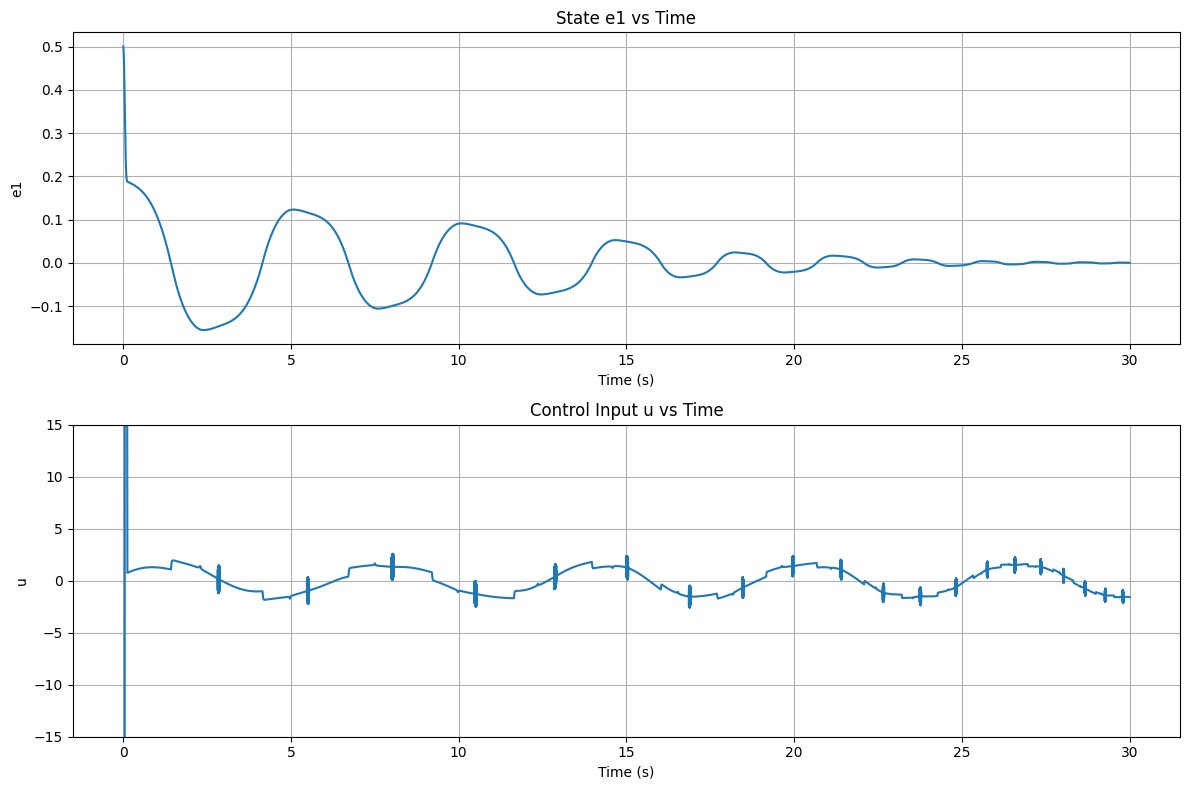

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
k1, k2, k3 = 23.4, 31.6, 20
l1, l2 = 2, 1.1
lam = 20
aN = 1
th1, th2 = 3, 1  # assumed values
w = 1
y0 = 1

# Initial conditions
x1_0, x2_0 = 0.5, 0.5
e1_0 = x1_0
e2_0 = x2_0 - w*y0
e1_hat_0, e2_hat_0 = 0, 0  # assumed observer initial conditions
sigma_0 = 0

# Simulation parameters
Ts = 3e-5
t_final = 30
t = np.arange(0, t_final, Ts)
N = len(t)

# Initialize arrays
e1 = np.zeros(N)
e2 = np.zeros(N)
e1_hat = np.zeros(N)
e2_hat = np.zeros(N)
u = np.zeros(N)
sigma = np.zeros(N)

# Set initial conditions
e1[0] = e1_0
e2[0] = e2_0
e1_hat[0] = e1_hat_0
e2_hat[0] = e2_hat_0
sigma[0] = sigma_0

# csign function (continuous sign function)
def csign(x, alpha):
    return np.sign(x) * np.abs(x)**alpha

# Simulation loop
for i in range(N-1):
    # Reference trajectory
    yR = y0 * np.sin(w * t[i])
    yR_ddot = -(w**2) * yR
    
    # Error between observer and actual states
    e1_err = e1_hat[i] - e1[i]
    
    # Control auxiliary variable
    u_aux = e1[i] + k2 * csign(e2_hat[i], 3/2)
    
    # Sliding variable
    sigma_dot = np.sign(e1[i])
    
    # Control input
    u[i] = -k1 * csign(u_aux, 1/3) - k3 * sigma[i]
    
    # System dynamics
    e1_dot = e2[i]
    e2_dot = -th1 * np.sin(e1[i] + yR) - yR_ddot + th2 * u[i]
    
    # Observer dynamics
    e1_hat_dot = -lam * l1 * csign(e1_err, 2/3) + e2_hat[i]
    e2_hat_dot = -lam**2 * l2 * csign(e1_err, 1/3) - k1 * aN * csign(u_aux, 1/3)
    
    # Euler integration
    e1[i+1] = e1[i] + Ts * e1_dot
    e2[i+1] = e2[i] + Ts * e2_dot
    e1_hat[i+1] = e1_hat[i] + Ts * e1_hat_dot
    e2_hat[i+1] = e2_hat[i] + Ts * e2_hat_dot
    sigma[i+1] = sigma[i] + Ts*sigma_dot

# Final control value
u[-1] = u[-2]

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, e1)
plt.xlabel('Time (s)')
plt.ylabel('e1')
plt.title('State e1 vs Time')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, u)
plt.xlabel('Time (s)')
plt.ylabel('u')
plt.ylim(-15,15)
plt.title('Control Input u vs Time')
plt.grid(True)

plt.tight_layout()
plt.show()